# Imports 

In [1]:
import numpy as np
import ipynb.fs.full.PrepareData as data
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import itertools

strategyArray = []
errorArray    = [[], []]

/home/leandro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
  9%|▉         | 4/43 [00:00<00:00, 39.54it/s]

[180, 89, 87, 87, 86, 89, 89, 88, 89, 86, 89, 89]
2 chs: 180 entries
3 chs: 89 entries
4 chs: 87 entries
5 chs: 87 entries
6 chs: 86 entries
7 chs: 89 entries
8 chs: 89 entries
9 chs: 88 entries
10 chs: 89 entries
15 chs: 86 entries
20 chs: 89 entries
30 chs: 89 entries


 74%|███████▍  | 32/43 [00:05<00:02,  5.41it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 88%|████████▊ | 38/43 [00:06<00:00,  6.82it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 28%|██▊       | 12/43 [00:00<00:02, 13.74it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 74%|███████▍  | 32/43 [00:04<00:01,  9.26it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 88%|████████▊ | 38/43 [00:04<00:00,  9.17it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 88%|████████▊ | 38/43 [00:05<00:00,  5.13it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 28%|██▊       | 12/43 [00:00<00:01, 15.70it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 88%|████████▊ | 38/43 [00:04<00:00,  8.20it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:05<00:00,  8.28it/s]


# Sorting the dataset

In [2]:
sortedDict = {}
commonRegressors = data.commonRegressors

for regressor in commonRegressors:
    sortedDict[regressor] = 0
    
    for i in range(data.ampNumber):
        sortedDict[regressor] += data.finalList[i][regressor][0] + data.finalList[i][regressor][1]

sortedDict = dict(sorted(sortedDict.items(), key = lambda x : x[1]))
sortedDict = dict(itertools.islice(sortedDict.items(), 5))

print(sortedDict.keys())

dict_keys(['LassoLarsIC', 'LassoLarsCV', 'Lasso', 'LassoCV', 'LarsCV'])


# Processing data

In [3]:
from sklearn.metrics import mean_absolute_error

def getMAE(yTrue, yPredicted):
    gainErrors = []
    lossErrors = []
    
    rangeList = list(range(len(yTrue[0])))
    
    for true, predicted in zip(yTrue, yPredicted):
        gainTrue      = [true[x] for x in rangeList[0::2]]
        gainPredicted = [predicted[x] for x in rangeList[0::2]]
        lossTrue      = [true[x] for x in rangeList[1::2]]
        lossPredicted = [predicted[x] for x in rangeList[1::2]]
        
        gainErrors.append(mean_absolute_error(gainTrue, gainPredicted))
        lossErrors.append(mean_absolute_error(lossTrue, lossPredicted))
        
    return gainErrors, lossErrors

# Plotting function

In [4]:
import matplotlib.pyplot as plt

def plotGrid(gainData, lossData):
    fig, axis = plt.subplots(2, figsize = (10, 10))
    #fig.suptitle("One regressor per variable - {} amplifiers".format(data.ampNumber), fontsize = 20)
    
    axis[0].boxplot(gainData)
    axis[0].set_title("Gain test error", fontsize = 18)
    axis[0].xaxis.set_tick_params(labelsize = 14)
    axis[0].set_ylim(0, 5)
    
    axis[1].boxplot(lossData)
    axis[1].set_title("Loss test error", fontsize = 18)
    axis[1].xaxis.set_tick_params(labelsize = 14)
    axis[1].set_xticklabels(strategyArray, rotation = -45, ha = 'left')
    axis[1].set_ylim(0, 5)

    fig.text(0.08, 0.5, 'Mean Absolute error (dB)', va='center', rotation='vertical', fontsize = 18)

    plt.gcf().subplots_adjust(bottom = 0.15)
    fig.savefig("../../graphs/perVar-{}amps.eps".format(data.ampNumber), format = 'eps', dpi = 1000, bbox_inches = "tight")

# Building the models

In [5]:
X, y = data.loadDataset()
X_train, X_test, y_train, y_test = data.train_test_split(X, y, test_size = 0.3, random_state = 0)

count = 1

In [6]:
from sklearn.neural_network import MLPRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model      = MultiOutputRegressor(MLPRegressor())
    
    param_grid = {
        'estimator__activation': ["identity", "logistic", "tanh", "relu"],
        'estimator__hidden_layer_sizes': [(100,), (50, 50)]
    }
    
    grid = GridSearchCV(model, param_grid = param_grid)
    grid.fit(X_train, y_train[:, i: i + 1])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 1])    
    
    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - MLPRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2420438843010586 +- 0.5291468706923065
Loss error: 0.8744293454373068 +- 0.5077932835873138


In [7]:
from sklearn.compose import TransformedTargetRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(TransformedTargetRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - TransformedTargetRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2494188862462197 +- 0.5599075849914698
Loss error: 0.8735609485257056 +- 0.5442244035089004


In [8]:
from sklearn.ensemble import RandomForestRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(RandomForestRegressor())
    
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__min_samples_split': [1, 3, 4, 5],
        'estimator__max_leaf_nodes': [None, 1, 5, 10]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 1])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - RandomForestRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2424834678968169 +- 0.5414251401172158
Loss error: 0.8726526476950316 +- 0.5144792470629379


In [9]:
from sklearn.ensemble import BaggingRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(BaggingRegressor())
    
    param_grid = {
        'estimator__n_estimators': [5, 50, 100]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 1])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - BaggingRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2474699420482362 +- 0.5436058648706139
Loss error: 0.8711768323263076 +- 0.5202364116120347


In [10]:
from sklearn.ensemble import ExtraTreesRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(ExtraTreesRegressor())
    
    param_grid = {
        'estimator__n_estimators': [5, 50, 100],
        'estimator__max_features': ['auto', 'sqrt', 'log2'],
        'estimator__max_depth': [5, 50, 100]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 1])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - ExtraTreesRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2435080427815604 +- 0.5394901825564787
Loss error: 0.8759637955915078 +- 0.5146992355079402


In [11]:
from sklearn.dummy import DummyRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2):
    model = MultiOutputRegressor(DummyRegressor())
    model.fit(X_train, y_train[:, i: i + 1])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 1]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 1]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - DummyRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.2363774461620947 +- 0.5181708407904929
Loss error: 0.9071039227951032 +- 0.5464564132029385


dict_keys(['LassoLarsIC', 'LassoLarsCV', 'Lasso', 'LassoCV', 'LarsCV'])


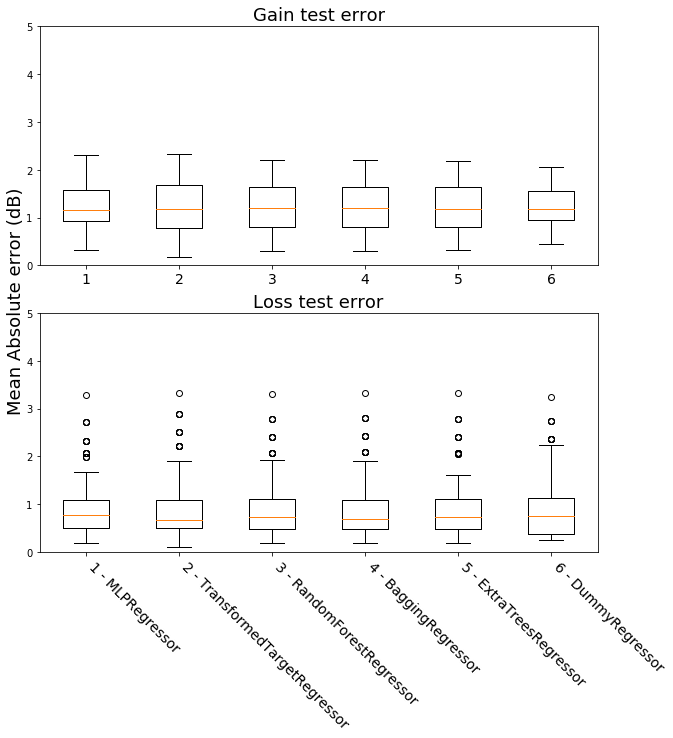

In [12]:
print(sortedDict.keys())
plotGrid(errorArray[0], errorArray[1])